#### Import libraries

In [126]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

#### Load the data set

In [2]:
train = np.genfromtxt ('letters.csv', delimiter=",")

In [3]:
n, m = train.shape

In [4]:
print(n, m)

7744 7000


#### Normalise data

In [6]:
def normalise_data(data, axis):
    """ Normalise every row/column of a matrix
    data - the matrix
    axis - the axis on which to normalise
    """ 
    #L2 norm
    l2_norm = np.linalg.norm(data, ord=2, axis=axis, keepdims=True)
    #normalise where norm!=0
    norm_data = np.divide(data, l2_norm, where=l2_norm!=0) 
    return norm_data

In [7]:
norm_data = normalise_data(train, 0)

All samples have L2 norm of 1 after normalisation

In [8]:
np.linalg.norm(norm_data, ord=2, axis=0, keepdims=True)[:10] 

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.]])

#### Display a letter

In [9]:
def show_letter(x, data):
    """ Displays a letter from the dataset given an index
    x - index of the vector in the data
    data - letters dataset
    """
    vec = train[:,x]                                      # get vector at index x
    vec_size = vec.size                                   # size of the letter vector
    img_size = int(math.sqrt(vec_size))                   # size for a 2D image
    img = np.reshape(vec,(img_size, img_size), order="F") # resize the vector
    plt.imshow(img, interpolation = 'nearest', cmap='inferno')

Display a random letter from the training set

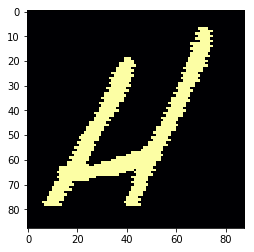

In [10]:
x = np.random.randint(m) # choose random index from training set
show_letter(x, norm_data)

#### Initialise hyperparameters

In [127]:
[n,m]  = np.shape(train)                    # number of pixels and number of training data
eta = 0.01                                  # learning rate
leaky_eta = eta / 1000
winit  = 1                                  # parameter controlling magnitude of initial conditions
alpha = 0.999
epochs = 5
digits = 20                                 # number of prototypes

In [128]:
counter = np.zeros((1,digits))              # counter for the winner neurons
wCount = np.ones(epochs*m) * 0.25           # running avg of the weight change over time

In [13]:
def init_random_weights(n, digits, winit):
    """ Initialise weights with random numbers
    drawn from a random distribution
    n - number of input units
    digits - number of output units
    winit - magnitude of initial conditions
    """
    W = np.random.rand(digits,n) * winit
    return normalise_data(W, 1)

In [14]:
def init_weights_from_data(data, digits):
    """ Initialise weights with random samples from
    training data
    data - training data
    digits - number of prototypes
    """
    n, m = data.shape
    # pick random indices from training data
    idx = np.random.randint(0, m, digits)
    # initialise W with the sample sat those indices
    W = data[:, idx].T
    return W

Initalisation using random weights

In [121]:
W = init_random_weights(n, digits, winit)

Make sure the random weights matrix are normalised i.e. L2 norm = 1

In [18]:
np.linalg.norm(W, ord=2, axis=1, keepdims=True)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

Initialisation using random samples from training data

In [58]:
W = init_weights_from_data(norm_data, digits)

#### Prototypes before training

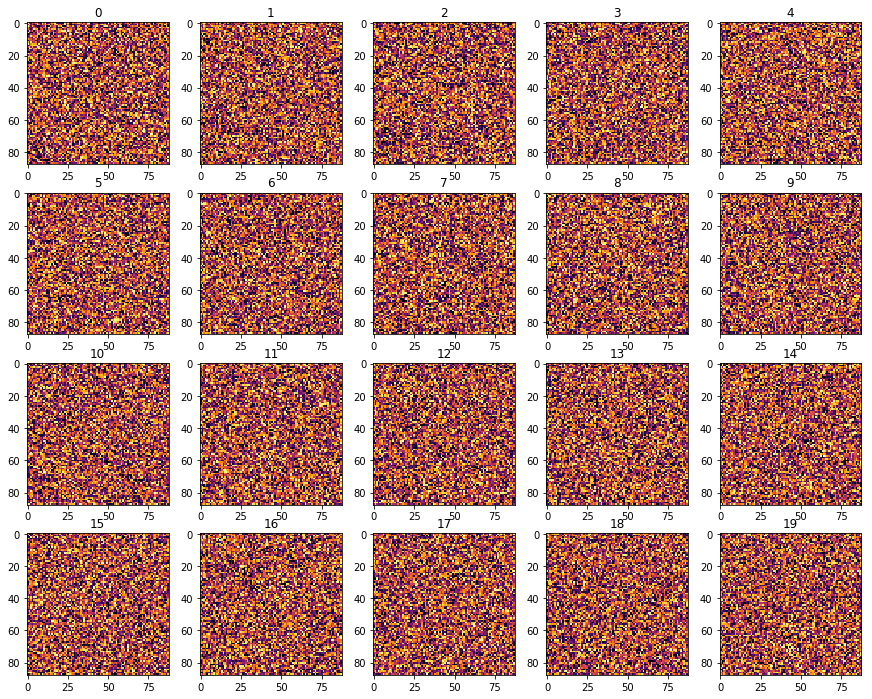

In [122]:
fig, axs = plt.subplots(4, 5, figsize=(15,12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(W[index,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
        axs[i, j].set_title(str(index))

#### Training

1) Training loop - updating only the winning neuron, without noise

In [288]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)   
    for i in range(m):
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

2) Training loop - updating only the winning neuron, using noise

In [59]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)
    
    for i in range(m):
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        noise = np.random.normal(0, 0.01, W[k,:].shape)
        noisy_output = W[k,:] + noise           # add noise to the output
        dw = eta * (x.T - noisy_output)         # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

3) Training loop - leaky learning, without noise

In [123]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)
    for i in range(m):
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        leaky_dw = leaky_eta * (x.T - noisy_output)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated
        W[(np.arange(digits) != k), :] = W[(np.arange(digits) != k), :] + leaky_dw # weights for the loser neurons
                                                                                   # are updated

4) Training loop - using leaky learning and noise

In [269]:
for b in range(epochs):
    idx = np.arange(m)
    np.random.shuffle(idx)
    for i in range(m):
        x = norm_data[:,idx[i]]                 # pick the next training instance in the training data

        h = W.dot(x)/digits                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

        output = np.max(h)                      # get the max in the output firing vector
        k = np.argmax(h)                        # get the index of the firing neuron
        counter[0,k] += 1                       # increment counter for winner neuron
        noise = np.random.normal(0, 0.01, W[k,:].shape)
        noisy_output = W[k,:] + noise
        dw = eta * (x.T - noisy_output)         # calculate the change in weights for the k-th output neuron
                                                # get closer to the input (x - W)
        leaky_dw = leaky_eta * (x.T - noisy_output)
        wCount[b*m+i] = wCount[b*m+i-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # weight change over time (running avg)

        W[k,:] = W[k,:] + dw                    # weights for k-th output are updated
        W[(np.arange(digits) != k), :] = W[(np.arange(digits) != k), :] + leaky_dw # weights for the loser neurons
                                                                                   # are updated

#### Prototypes after training

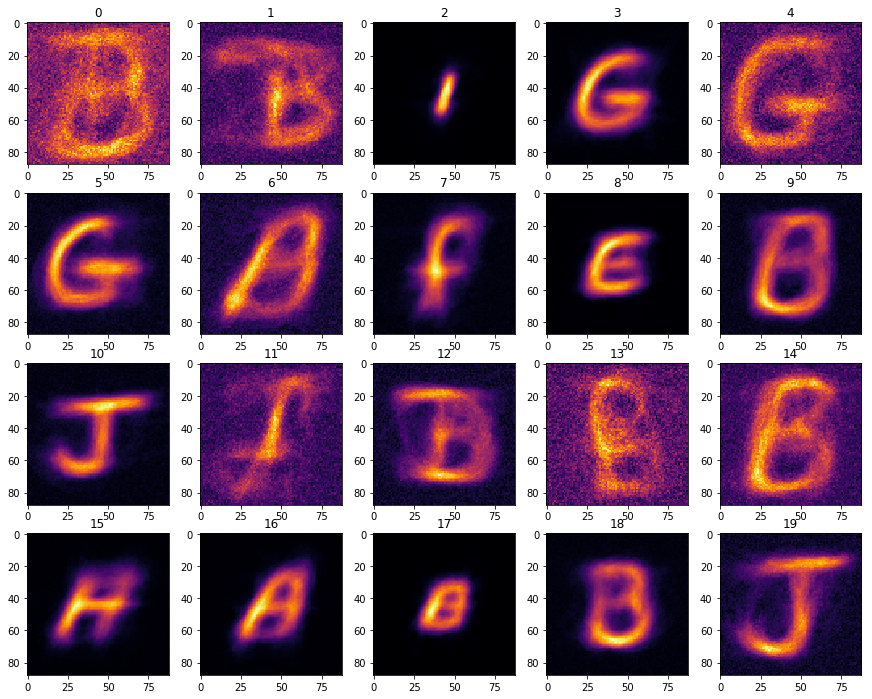

In [124]:
fig, axs = plt.subplots(4, 5, figsize=(15,12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(W[index,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
        axs[i, j].set_title(str(index))

#### Distribution of winning neurons

In [19]:
def get_dead_units_percentage(counts, threshold):
    """ Returns the percentage of dead units
    counts - array containing the number of times each prototype won
    threshold - threshold below which a neuron is dead
    """
    # convert counts into percentages
    percentages = counts / counts.sum() 
    # get the number of percentages below the threshold
    dead_units = np.sum((percentages < threshold).astype(np.float)) 
    # return percentage of dead units
    return dead_units / counts.size

In [125]:
get_dead_units_percentage(counter, 0.01)

0.34999999999999998

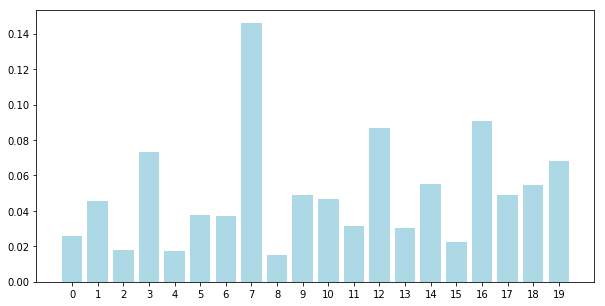

In [55]:
# plot distribution of winning counts percentages 
plt.figure(figsize=(10,5))
plt.bar(np.arange(counter.size) , counter[0,:]/ counter.sum(), color='lightblue')
plt.xticks(np.arange(counter.size))
plt.show()

#### Weight change over time

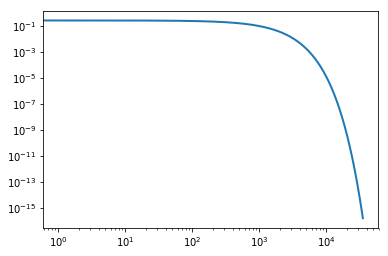

In [31]:
# Plot running average on a log-log axes
plt.loglog(wCount[0:epochs*m], linewidth=2.0, label='rate')

#### Correlation between prototypes

In [211]:
corr = np.corrcoef(W) # correlation matrix between prototypes

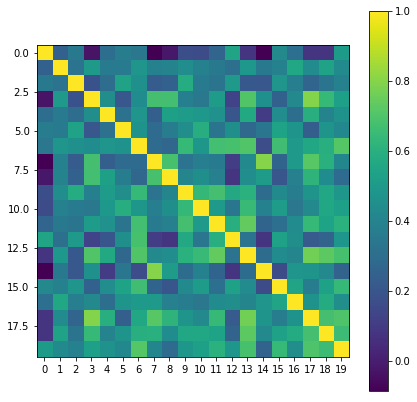

In [212]:
# plot correlation matrix
plt.figure(figsize=(7,7))
plt.xticks(np.arange(counter.size))
plt.imshow(corr)
plt.colorbar()

#### Highly correlated prototypes

Print the pairs of prototypes that are highly correlated

In [213]:
def highly_correlated_prototypes(corr, threshold):
    """ Print pairs of highly correlated prototypes
    corr - correlation matrix
    threshold - threshold above which the protoytpes 
    are highly correlated
    """
    high_corr = corr > threshold
    a, _ = high_corr.shape
    for i in range(a - 1):
        for j in range(i+1, a):
            if(high_corr[i, j]):
                print(i, j)

In [214]:
highly_correlated_prototypes(corr, 0.8)

3 17
7 14
